## Import required libraries

In [1]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from sklearn                              import  metrics
from statsmodels.tsa.vector_ar.vecm       import  coint_johansen
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.tsa.api                  import  VAR
from statsmodels.tsa.statespace.varmax    import  VARMAX
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## read Stock Price data

In [2]:
df=pd.read_csv('varma_data.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-14,16159.009766,16482.050781,16075.120117,16379.049805,16379.049805,158830000
1,2016-01-15,16354.330078,16354.330078,15842.110352,15988.080078,15988.080078,239210000
2,2016-01-19,16009.450195,16171.959961,15900.250000,16016.019531,16016.019531,144360000
3,2016-01-20,15989.450195,15989.450195,15450.559570,15766.740234,15766.740234,191870000
4,2016-01-21,15768.870117,16038.589844,15704.660156,15882.679688,15882.679688,145140000


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1001,2020-01-07,28639.179688,28685.500000,28565.279297,28583.679688,28583.679688,258900000
1002,2020-01-08,28556.140625,28866.179688,28522.509766,28745.089844,28745.089844,291750000
1003,2020-01-09,28851.970703,28988.009766,28844.310547,28956.900391,28956.900391,275060000
1004,2020-01-10,28977.519531,29009.070313,28789.099609,28823.769531,28823.769531,237830000
1005,2020-01-13,28869.009766,28909.910156,28819.429688,28907.050781,28907.050781,249830000


## convert data into time series

In [5]:
date = pd.date_range(start='1/14/2016', end='1/13/2020', freq='B')
date

DatetimeIndex(['2016-01-14', '2016-01-15', '2016-01-18', '2016-01-19',
               '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-25',
               '2016-01-26', '2016-01-27',
               ...
               '2019-12-31', '2020-01-01', '2020-01-02', '2020-01-03',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-13'],
              dtype='datetime64[ns]', length=1043, freq='B')

In [6]:
df['Time_Stamp'] = pd.DataFrame(date)
df=df.set_index('Time_Stamp')

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Time_Stamp,,,,,,,
2016-01-14,2016-01-14,16159.009766,16482.050781,16075.120117,16379.049805,16379.049805,158830000
2016-01-15,2016-01-15,16354.330078,16354.330078,15842.110352,15988.080078,15988.080078,239210000
2016-01-18,2016-01-19,16009.450195,16171.959961,15900.250000,16016.019531,16016.019531,144360000
2016-01-19,2016-01-20,15989.450195,15989.450195,15450.559570,15766.740234,15766.740234,191870000
2016-01-20,2016-01-21,15768.870117,16038.589844,15704.660156,15882.679688,15882.679688,145140000


In [8]:
df.drop(['Date','Adj Close','Volume'],axis=1,inplace=True)

## plot the time series

<AxesSubplot:xlabel='Time_Stamp'>

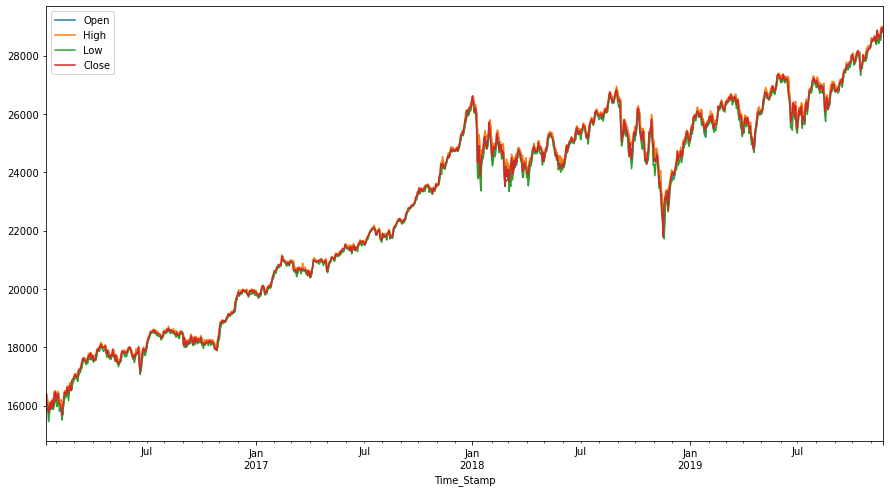

In [9]:
rcParams['figure.figsize'] = 15,8
df.plot()

## check for stationarity

In [10]:
def adfuller_test(series,name=''):
    observations= series.values
    test_result = adfuller(observations)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print('ADF Statistic: %f' % test_result[0])
    print('p-value: %f' % test_result[1])
    print('Critical Values:')
    for key, value in test_result[4].items():
            	print('\t%s: %.5f' % (key, value))

In [11]:
for name, column in df.iteritems():
    adfuller_test(column,name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
ADF Statistic: -1.097089
p-value: 0.716231
Critical Values:
	1%: -3.43702
	5%: -2.86448
	10%: -2.56834


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
ADF Statistic: -1.005190
p-value: 0.751367
Critical Values:
	1%: -3.43688
	5%: -2.86442
	10%: -2.56831


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
ADF Statistic: -1.147396
p-value: 0.695806
Critical Values:
	1%: -3.43701
	5%: -2.86448
	10%: -2.56834


    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
ADF Statistic: -1.015406
p-value: 0.747604
Critical Values:
	1%: -3.43687
	5%: -2.86442
	10%: -2.56830




## If series is not stationary, use differencing to make the series stationary

In [12]:
df_diff = df.diff().dropna()

In [13]:
df_diff.head()

,Open,High,Low,Close
Time_Stamp,,,,
2016-01-15,195.320312,-127.720703,-233.009765,-390.969727
2016-01-18,-344.879883,-182.370117,58.139648,27.939453
2016-01-19,-20.000000,-182.509766,-449.690430,-249.279297
2016-01-20,-220.580078,49.139649,254.100586,115.939454
2016-01-21,152.229492,98.200195,216.439453,210.830078


In [14]:
for name, column in df_diff.iteritems():
    adfuller_test(column,name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
ADF Statistic: -6.981338
p-value: 0.000000
Critical Values:
	1%: -3.43703
	5%: -2.86449
	10%: -2.56834


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
ADF Statistic: -30.177626
p-value: 0.000000
Critical Values:
	1%: -3.43688
	5%: -2.86442
	10%: -2.56831


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
ADF Statistic: -7.435368
p-value: 0.000000
Critical Values:
	1%: -3.43701
	5%: -2.86448
	10%: -2.56834


    Augmented Dickey-Fuller Test on "Close" 
    -----------------------------------------------
ADF Statistic: -32.558297
p-value: 0.000000
Critical Values:
	1%: -3.43688
	5%: -2.86442
	10%: -2.56831




## establish the presence of a statistically significant connection between time series variables using Cointegration test for alpha= 0.05.

In [15]:
out = coint_johansen(df,1,1)

In [16]:
out

In [17]:
out.lr1

array([1186.34616045,  561.68580257,  133.36365421,    9.56472129])

In [20]:
out.cvt

array([[51.6492, 55.2459, 62.5202],
       [32.0645, 35.0116, 41.0815],
       [16.1619, 18.3985, 23.1485],
       [ 2.7055,  3.8415,  6.6349]])

In [ ]:
#lr1:-trace values (sum of eigen values)
#lr2:-max eigen values


#cvt:-critical values for traces
#cvm:-critical values for max eigen value

In [21]:
out.lr2

array([624.66035788, 428.32214836, 123.79893293,   9.56472129])

In [22]:
out.cvm

array([[28.2398, 30.8151, 36.193 ],
       [21.8731, 24.2522, 29.2631],
       [15.0006, 17.1481, 21.7465],
       [ 2.7055,  3.8415,  6.6349]])

In [ ]:
out.cvm[:,1]

In [24]:
def cointegration_test(df, alpha=0.01): 
    out = coint_johansen(df,1,1)
    d = {'0.90':0, '0.95':1,'0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]] #cvts=out.cvt[:,1]
    def adjust(val, length= 10): return str(val).ljust(length)
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open       ::  1186.35   > 62.5202   =>   True
High       ::  561.69    > 41.0815   =>   True
Low        ::  133.36    > 23.1485   =>   True
Close      ::  9.56      > 6.6349    =>   True


## split the series into training and testing sets

In [10]:
train_end=datetime(2019,7,31)
test_end=datetime(2020,1,13)

In [11]:
train             = df[:train_end] 
test              = df[train_end + timedelta(days=1):test_end]

In [12]:
train.shape

(925, 4)

In [13]:
test.shape

(81, 4)

In [14]:
train1=train.diff().dropna()

In [30]:
model=VAR(train1)
result=model.fit(4)
result.aic

35.73446676709522

In [31]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 03, Oct, 2021
Time:                     12:33:12
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    36.0911
Nobs:                     920.000    HQIC:                   35.8705
Log likelihood:          -21591.5    FPE:                3.30589e+15
AIC:                      35.7345    Det(Omega_mle):     3.07243e+15
--------------------------------------------------------------------
Results for equation Open
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            3.166560         2.682468            1.180           0.238
L1.Open         -0.672879         0.058412          -11.520           0.000
L1.High         -0.073208         0.046646           -1.569           0.117
L1.Lo

##  select the right order of the VAR model for least AIC.

In [33]:
model = VAR(train1)
for i in range(1,30):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)

Lag Order = 1
AIC :  36.46917577217586
Lag Order = 2
AIC :  36.001125704182556
Lag Order = 3
AIC :  35.80106903587586
Lag Order = 4
AIC :  35.73446676709522
Lag Order = 5
AIC :  35.62837018312925
Lag Order = 6
AIC :  35.58853294968405
Lag Order = 7
AIC :  35.52817308433611
Lag Order = 8
AIC :  35.50768097733879
Lag Order = 9
AIC :  35.49574339934622
Lag Order = 10
AIC :  35.482245284449576
Lag Order = 11
AIC :  35.44730675926857
Lag Order = 12
AIC :  35.42100313884424
Lag Order = 13
AIC :  35.39373043656055
Lag Order = 14
AIC :  35.40113055133295
Lag Order = 15
AIC :  35.38851092257697
Lag Order = 16
AIC :  35.375365140258324
Lag Order = 17
AIC :  35.3585014537221
Lag Order = 18
AIC :  35.34790139437608
Lag Order = 19
AIC :  35.34312547035543
Lag Order = 20
AIC :  35.34300795235263
Lag Order = 21
AIC :  35.32375935975019
Lag Order = 22
AIC :  35.33501785078329
Lag Order = 23
AIC :  35.34224660954671
Lag Order = 24
AIC :  35.35224904594963
Lag Order = 25
AIC :  35.357306788820736
Lag Or

## Train the VAR model for selected order

In [34]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 03, Oct, 2021
Time:                     12:41:50
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    36.1380
Nobs:                     917.000    HQIC:                   35.7609
Log likelihood:          -21378.3    FPE:                2.68984e+15
AIC:                      35.5282    Det(Omega_mle):     2.37487e+15
--------------------------------------------------------------------
Results for equation Open
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.559029         2.618197            0.977           0.328
L1.Open         -0.789651         0.060408          -13.072           0.000
L1.High         -0.075386         0.046911           -1.607           0.108
L1.Lo

## forecast using fitted model

In [35]:
forecast_input = train1.values[-7:]
forecast_input

array([[  75.980469,   39.960937,   53.789063,   38.048828],
       [ -60.400391,    8.59961 ,  -45.128907,   73.919922],
       [ 122.220703,  227.609375,  168.429688,  227.609375],
       [ 269.269532,  169.691406,  219.529297,   45.410156],
       [  19.349609,  -29.179688,   88.939453,   37.070312],
       [ -70.609375, -104.68164 , -161.388672, -142.699218],
       [-135.941406,  -62.06836 ,  -48.419922,   33.980468]])

In [36]:
len(test)

81

In [37]:
forecast=model_fitted.forecast(y=forecast_input,steps=len(test))

forecast=pd.DataFrame(forecast,index=test.index, columns=df.columns)

In [38]:
forecast

,Open,High,Low,Close
Time_Stamp,,,,
2019-08-01,82.937148,66.692851,42.133041,19.841563
2019-08-02,25.371890,22.932000,28.422703,39.309339
2019-08-05,56.699508,59.394195,56.906996,54.129270
2019-08-06,47.447742,36.694421,33.757858,-0.914738
2019-08-07,-19.898659,-7.715384,3.252097,6.791802
...,...,...,...,...
2019-11-15,11.918789,11.850140,11.997626,11.941487
2019-11-18,11.918786,11.850132,11.997620,11.941482
2019-11-19,11.918781,11.850131,11.997616,11.941479


In [39]:
test

,Open,High,Low,Close
Time_Stamp,,,,
2019-08-01,27075.390625,27161.929688,26899.150391,27147.080078
2019-08-02,27186.050781,27272.169922,27064.210938,27094.789063
2019-08-05,27102.179688,27194.750000,26926.679688,26935.070313
2019-08-06,26851.449219,27011.070313,26831.339844,26949.990234
2019-08-07,27034.070313,27079.679688,26704.960938,26807.769531
...,...,...,...,...
2019-11-15,28639.179688,28685.500000,28565.279297,28583.679688
2019-11-18,28556.140625,28866.179688,28522.509766,28745.089844
2019-11-19,28851.970703,28988.009766,28844.310547,28956.900391


In [ ]:
forecast.head()

## If differencing is done, Invert the transformation to get the real forecast

In [22]:
def invert_transformation(train, forecast):
    df_fc = forecast.copy()
    columns = train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [ ]:
    for col in columns:        
        df_fc[str(col)+'_1d'] = (train[col].iloc[-1]-train[col].iloc[-2]) + df_fc[str(col)].cumsum()
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [41]:
df_results = invert_transformation(train,forecast)

In [42]:
df_results.head()

,Open,High,Low,Close,Open_forecast,High_forecast,Low_forecast,Close_forecast
Time_Stamp,,,,,,,,
2019-08-01,82.937148,66.692851,42.133041,19.841563,27093.056289,27177.493632,27026.273666,27130.642344
2019-08-02,25.371890,22.932000,28.422703,39.309339,27118.428179,27200.425632,27054.696369,27169.951683
2019-08-05,56.699508,59.394195,56.906996,54.129270,27175.127687,27259.819827,27111.603364,27224.080953
2019-08-06,47.447742,36.694421,33.757858,-0.914738,27222.575429,27296.514249,27145.361223,27223.166215
2019-08-07,-19.898659,-7.715384,3.252097,6.791802,27202.676770,27288.798865,27148.613320,27229.958017


In [43]:
test.head()

,Open,High,Low,Close
Time_Stamp,,,,
2019-08-01,27075.390625,27161.929688,26899.150391,27147.080078
2019-08-02,27186.050781,27272.169922,27064.210938,27094.789063
2019-08-05,27102.179688,27194.750000,26926.679688,26935.070313
2019-08-06,26851.449219,27011.070313,26831.339844,26949.990234
2019-08-07,27034.070313,27079.679688,26704.960938,26807.769531


## plot the results

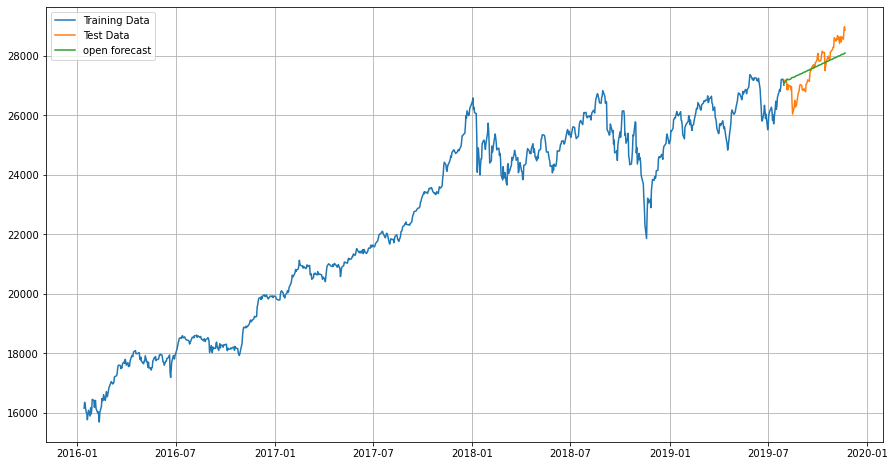

In [44]:
plt.plot(train['Open'],label='Training Data')
plt.plot(test['Open'],label='Test Data')
plt.plot(test.index,df_results['Open_forecast'],label='open forecast')
plt.legend(loc='best')
plt.grid();

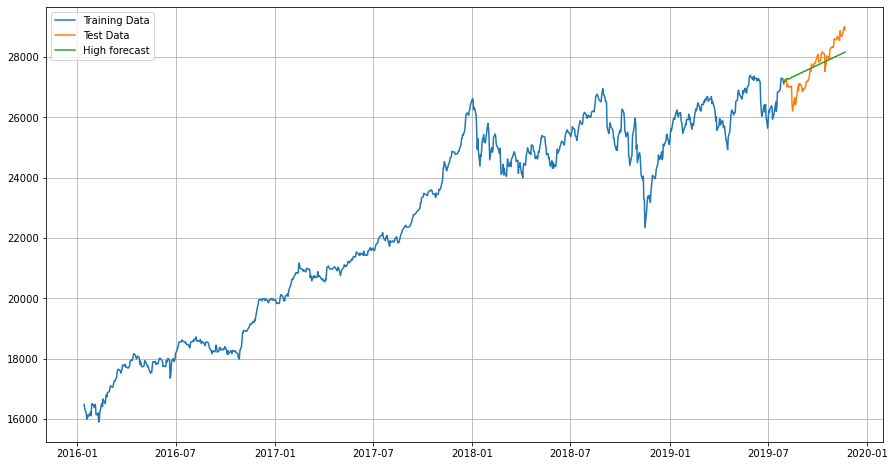

In [45]:
plt.plot(train['High'],label='Training Data')
plt.plot(test['High'],label='Test Data')
plt.plot(test.index,df_results['High_forecast'],label='High forecast')
plt.legend(loc='best')
plt.grid();

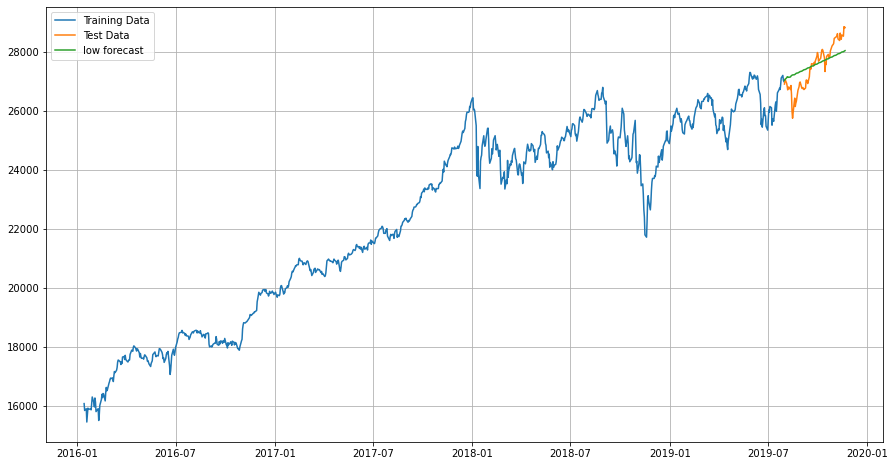

In [46]:
plt.plot(train['Low'],label='Training Data')
plt.plot(test['Low'],label='Test Data')
plt.plot(test.index,df_results['Low_forecast'],label='low forecast')
plt.legend(loc='best')
plt.grid();

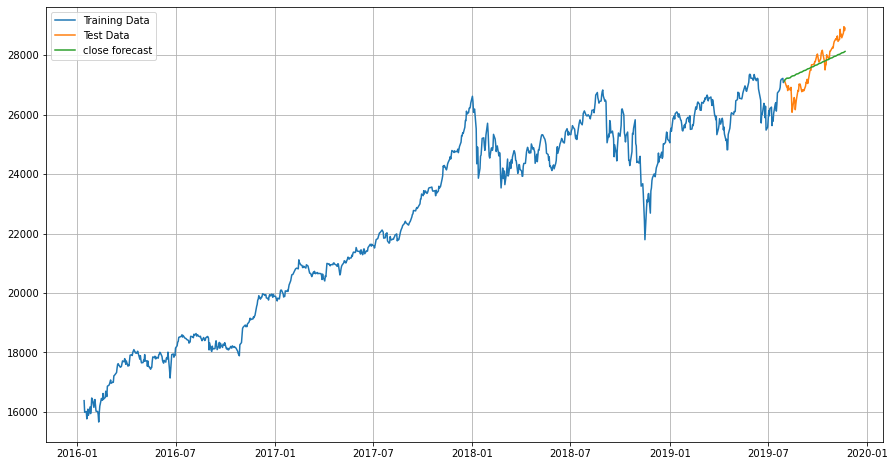

In [47]:
plt.plot(train['Close'],label='Training Data')
plt.plot(test['Close'],label='Test Data')
plt.plot(test.index,df_results['Close_forecast'],label='close forecast')
plt.legend(loc='best')
plt.grid();

## Model Performace

In [27]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [49]:
mape=MAPE(test['Close'].values,df_results['Close_forecast'].values)
print(mape)

1.515971581212565


In [50]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test['Open'],df_results['Open_forecast'], squared=False)
print(rmse)

490.3700148587564


## Building VARMA model

In [51]:
import itertools
p = q = range(0, 7)
pq = list(itertools.product(p,q))
print('parameter combinations for the Model')
for i in range(1,len(pq)):
    print('Model: {}'.format(pq[i]))

parameter combinations for the Model
Model: (0, 1)
Model: (0, 2)
Model: (0, 3)
Model: (0, 4)
Model: (0, 5)
Model: (0, 6)
Model: (1, 0)
Model: (1, 1)
Model: (1, 2)
Model: (1, 3)
Model: (1, 4)
Model: (1, 5)
Model: (1, 6)
Model: (2, 0)
Model: (2, 1)
Model: (2, 2)
Model: (2, 3)
Model: (2, 4)
Model: (2, 5)
Model: (2, 6)
Model: (3, 0)
Model: (3, 1)
Model: (3, 2)
Model: (3, 3)
Model: (3, 4)
Model: (3, 5)
Model: (3, 6)
Model: (4, 0)
Model: (4, 1)
Model: (4, 2)
Model: (4, 3)
Model: (4, 4)
Model: (4, 5)
Model: (4, 6)
Model: (5, 0)
Model: (5, 1)
Model: (5, 2)
Model: (5, 3)
Model: (5, 4)
Model: (5, 5)
Model: (5, 6)
Model: (6, 0)
Model: (6, 1)
Model: (6, 2)
Model: (6, 3)
Model: (6, 4)
Model: (6, 5)
Model: (6, 6)


In [52]:
dfObj1 = pd.DataFrame(columns=['param', 'AIC'])
dfObj1

,param,AIC


In [ ]:
for param in pq:
            try:
                mod = VARMAX(train1,order=param,trend='t')
                results_VARMAX = mod.fit()
                print('VARMAX{} - AIC:{}'.format(param, results_VARMAX.aic))
                dfObj1 = dfObj1.append({'param':param, 'AIC': results_VARMAX.aic}, ignore_index=True)

            except:
                continue

VARMAX(0, 1) - AIC:43601.71486043258


In [ ]:
dfObj1.sort_values(by=['AIC'])

In [15]:
model = VARMAX(train1, order=(3,3))

In [16]:
model_fit = model.fit(disp=False)

In [17]:
model_fit.summary()

Dep. Variable:,"['Open', 'High', 'Low', 'Close']",No. Observations:,924
Model:,"VARMA(3,3)",Log Likelihood,-21549.917
,+ intercept,AIC,43319.835
Date:,"Sun, 03 Oct 2021",BIC,43850.993
Time:,13:09:28,HQIC,43522.485
Sample:,01-15-2016,,
,- 07-31-2019,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1.04, 1.48, 0.04, 0.27",Jarque-Bera (JB):,"1055.90, 1222.06, 11264.10, 994.93"
Prob(Q):,"0.31, 0.22, 0.84, 0.61",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"9.24, 2.51, 3.76, 3.80",Skew:,"-0.61, 1.06, -2.27, -0.32"


In [18]:
forecast_input=train1[-3:]
forecast_input

,Open,High,Low,Close
Time_Stamp,,,,
2019-07-29,19.349609,-29.179688,88.939453,37.070312
2019-07-30,-70.609375,-104.681640,-161.388672,-142.699218
2019-07-31,-135.941406,-62.068360,-48.419922,33.980468


In [19]:
forecast=model_fit.forecast(y=forecast_input,steps=len(test))

In [20]:
forecast.head()

,Open,High,Low,Close
2019-08-01,97.351007,84.279030,57.218379,32.793679
2019-08-02,29.007024,9.199107,26.836989,14.102420
2019-08-05,18.212598,31.260721,27.344084,37.304416
2019-08-06,30.009269,17.809171,14.231189,2.628117
2019-08-07,5.421137,7.574763,7.788006,10.916714


In [23]:
df_results = invert_transformation(train,forecast)

In [24]:
df_results.head()

,Open,High,Low,Close,Open_forecast,High_forecast,Low_forecast,Close_forecast
2019-08-01,97.351007,84.279030,57.218379,32.793679,27107.470148,27195.079811,27041.359004,27143.594460
2019-08-02,29.007024,9.199107,26.836989,14.102420,27136.477172,27204.278918,27068.195994,27157.696879
2019-08-05,18.212598,31.260721,27.344084,37.304416,27154.689769,27235.539638,27095.540077,27195.001295
2019-08-06,30.009269,17.809171,14.231189,2.628117,27184.699038,27253.348809,27109.771267,27197.629412
2019-08-07,5.421137,7.574763,7.788006,10.916714,27190.120175,27260.923571,27117.559272,27208.546126


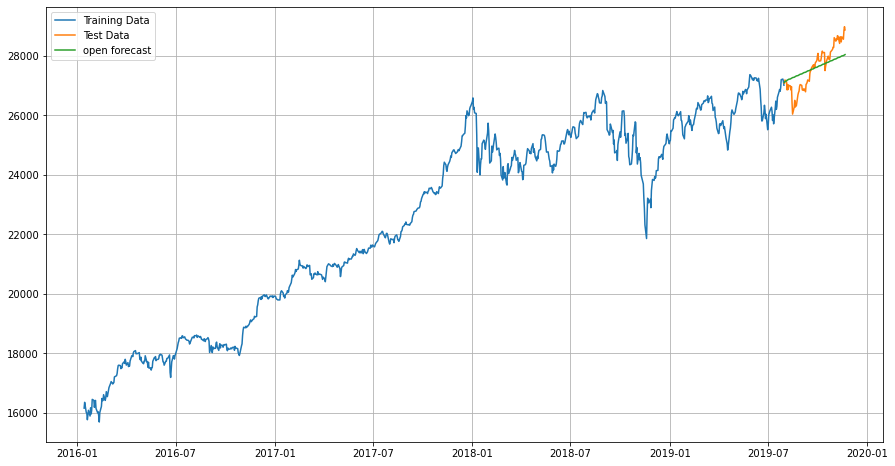

In [25]:
plt.plot(train['Open'],label='Training Data')
plt.plot(test['Open'],label='Test Data')
plt.plot(test.index,df_results['Open_forecast'],label='open forecast')
plt.legend(loc='best')
plt.grid();

In [28]:
mape=MAPE(test['Open'].values,df_results['Open_forecast'].values)
print(mape)

1.5060469429805308


In [29]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test['Open'],df_results['Open_forecast'], squared=False)
print(rmse)

502.8417668845172


## END

### ARIMA Convergence issue

In [10]:
from statsmodels.tsa.arima_model          import  ARIMA

In [12]:
df=df[['Open']]

In [14]:
model=ARIMA(df,order=(1,0,1))
model=model.fit()

## if you face convergence issue while training the model, modify model.fit using any one of the following method for parameter estimation.
## This is the method  likelihood will use for maximize its value.

In [16]:
model=ARIMA(df,order=(1,0,1))
model=model.fit(method ='css-mle')

In [17]:
model=ARIMA(df,order=(1,0,1))
model=model.fit(method ='mle')

In [19]:
model=ARIMA(df,order=(1,0,1))
model=model.fit(method ='css')